In [36]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
pd.set_option("display.max_rows", 500)
import warnings
warnings.filterwarnings("ignore")

# Source Data
# https://www.kaggle.com/c/ih-hotel-booking


In [37]:
url = "https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_hotel_traintest.csv"
tb_hotel = pd.read_csv(url, parse_dates=["arrival_date", "reservation_status_date"])


In [38]:
tb_hotel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113409 entries, 0 to 113408
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           113409 non-null  object        
 1   is_cancelled                    113409 non-null  int64         
 2   lead_time                       113409 non-null  int64         
 3   stays_in_weekend_nights         113409 non-null  int64         
 4   stays_in_week_nights            113409 non-null  int64         
 5   adults                          113409 non-null  int64         
 6   children                        113406 non-null  float64       
 7   babies                          113409 non-null  int64         
 8   meal                            113409 non-null  object        
 9   country                         112951 non-null  object        
 10  market_segment                  113409 non-null  object 

In [39]:
tb_hotel['is_cancelled'].describe()

count    113409.000000
mean          0.370658
std           0.482983
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: is_cancelled, dtype: float64

# Building & Evaluating Models in SKLEARN

In [40]:
def clean_hotel_data(hotel_data):
    hotel_data["children"] = hotel_data["children"].fillna(0)
    hotel_data["country"] = hotel_data["country"].fillna("Unknown")
    hotel_data["is_company"] = np.where(hotel_data["company"].isna(), 0, 1)
    hotel_data["is_agent"] = np.where(hotel_data["agent"].isna(), 0, 1)
    hotel_data = hotel_data.drop(
        ["company", "agent", "id_booking", "reservation_status_date"], axis=1
    ).dropna()

    return hotel_data


In [44]:
tb_hotel_clean = clean_hotel_data(tb_hotel)

cat_vars = list(tb_hotel_clean.select_dtypes(include="object").columns)
num_vars = list(tb_hotel_clean.select_dtypes(include="number").drop("is_cancelled", axis=1).columns)


In [45]:
num_vars

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'is_company',
 'is_agent']

In [46]:
X = tb_hotel_clean.drop("is_cancelled", axis=1)
y = tb_hotel_clean["is_cancelled"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [47]:
X_train_num = X_train.select_dtypes(include="number")
X_test_num = X_test[X_train_num.columns]


## Building a simple model

In [48]:
power_trans = PowerTransformer()
scaler = StandardScaler()
pca = PCA()
dt_fit = DecisionTreeClassifier()
log_fit = LogisticRegression()

X_train_num_t = power_trans.fit_transform(X_train_num)
#power_trans.fit(X_train_num)
#X_train_num_t = power_trans.transform(X_train_num)
X_train_num_s = scaler.fit_transform(X_train_num_t)
X_train_num_p = pca.fit_transform(X_train_num_s)


In [49]:
X_train_num_p

array([[ 1.2924263 , -1.32962888, -0.84878355, ...,  1.10603404,
         0.19332672,  0.16145615],
       [-0.96166797, -2.70107421,  0.58372159, ...,  0.07068095,
         0.0431116 , -0.1313557 ],
       [-0.08770536, -0.6648112 , -1.07399632, ..., -0.35919329,
         0.18105616,  0.05299243],
       ...,
       [-0.70252666, -0.60512707,  0.31210902, ...,  0.4262294 ,
         0.16831842,  0.03184866],
       [-0.61383912, -0.23636466, -0.43609509, ..., -0.0285662 ,
         0.15199428,  0.00980434],
       [-0.1636643 ,  3.45798669, -0.45634411, ...,  1.07338125,
         0.59813458,  0.00797991]])

In [50]:
log_fit.fit(X_train_num_p, y_train)


LogisticRegression()

In [51]:
para_grid = {
    "max_depth": [int(x) for x in np.linspace(1, 150, 5)],
    "min_samples_split": [int(x) for x in np.linspace(2, 100, 5)],
    "min_samples_leaf": [int(x) for x in np.linspace(1, 50, 5)],
}

cv_fit = GridSearchCV(dt_fit, param_grid=para_grid, n_jobs = 2)
cv_fit.fit(X_train_num_p, y_train)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 38, 75, 112, 150],
                         'min_samples_leaf': [1, 13, 25, 37, 50],
                         'min_samples_split': [2, 26, 51, 75, 100]})

In [52]:
cv_fit.best_estimator_

DecisionTreeClassifier(max_depth=38)

In [57]:
cv_results = pd.DataFrame(cv_fit.cv_results_)

In [59]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

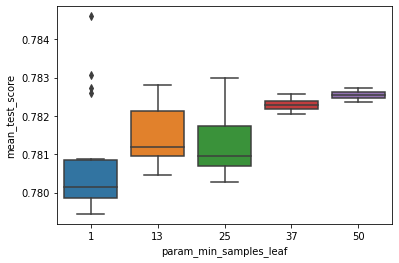

In [62]:
sns.boxplot(data = cv_results[cv_results['param_max_depth'] > 10], x = 'param_min_samples_leaf', y = 'mean_test_score')

### Evaluating models

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [66]:
X_test_num_t = power_trans.transform(X_test_num)
X_test_num_s = scaler.transform(X_test_num_t)
X_test_num_p = pca.transform(X_test_num_s)


In [67]:
y_pred_log = log_fit.predict(X_test_num_p)
y_pred_dt = cv_fit.predict(X_test_num_p)


In [69]:
y_pred_dt

array([1, 1, 1, ..., 1, 1, 1])

#### Accuracy

*Out of all predicitions, what % were correct?*

In [70]:
log_acc = np.round(accuracy_score(y_test, y_pred_log), 2)
dt_acc = np.round(accuracy_score(y_test, y_pred_dt), 2)


In [72]:
print(f"Logistic Regression Accuracy: {log_acc}")
print(f"D.T. Regression Accuracy: {dt_acc}")


Logistic Regression Accuracy: 0.75
D.T. Regression Accuracy: 0.79


#### Precision

*Out of all cancellation predicitions, what % were correct?*

**Precision is the ratio between True Positives (correct positive predictions) and True+False Positives (all positive predictions).**

In [73]:
log_prc = np.round(precision_score(y_test, y_pred_log), 2)
dt_prc = np.round(precision_score(y_test, y_pred_dt), 2)

print(f"Logistic Regression Precision: {log_prc}")
print(f"D.T. Regression Precision: {dt_prc}")


Logistic Regression Precision: 0.71
D.T. Regression Precision: 0.71


#### Recall

*Out of all real cancellations, what % were correctly predicted?*

**Recall is the ration between True Positives (correct positive predictions) and Real Positives (observed positive outcomes).**

In [74]:
log_rec = np.round(recall_score(y_test, y_pred_log), 2)
dt_rec = np.round(recall_score(y_test, y_pred_dt), 2)

print(f"Logistic Regression Recall: {log_rec}")
print(f"D.T. Regression Recall: {dt_rec}")


Logistic Regression Recall: 0.57
D.T. Regression Recall: 0.71


In [77]:
sum(y_pred_dt)

10506

In [78]:
sum(y_pred_log)

8488

#### f1-Score

**The *harmonic mean* between precision and recall:**

$$f_1 = 2 \frac{precision * recall}{precision + recall}$$

A **f1-score = 1** means our model has perfect precision (all its cancellation predictions were cancellations) and perfect recall (all observed cancellations were predicted correctly). The lower the f1-score the farther we are from a good model.

In [79]:
log_f1 = np.round(f1_score(y_test, y_pred_log), 2)
dt_f1 = np.round(f1_score(y_test, y_pred_dt), 2)

print(f"Logistic Regression F1: {log_f1}")
print(f"D.T. Regression F1: {dt_f1}")


Logistic Regression F1: 0.63
D.T. Regression F1: 0.71


In [82]:
log_rec

0.57

In [81]:
dt_prc

0.71

#### Utilizing precision, recall and F1 for model evaluation

In [83]:
def evaluate_model(y_true, y_pred):
    prc = np.round(precision_score(y_true, y_pred), 2)
    f1 = np.round(f1_score(y_true, y_pred), 2)
    rec = np.round(recall_score(y_true, y_pred), 2)

    print(f"Model F1: {f1}")
    print(f"Model Precision: {prc}")
    print(f"Model Recall: {rec}")


In [84]:
evaluate_model(y_test, y_pred_log)


Model F1: 0.63
Model Precision: 0.71
Model Recall: 0.57


In [85]:
evaluate_model(y_test, y_pred_dt)

Model F1: 0.71
Model Precision: 0.71
Model Recall: 0.71


## Building Pipelines

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


In [99]:
power_trans = PowerTransformer()
scaler = StandardScaler()
pca = PCA()
dt_fit = DecisionTreeClassifier()

In [100]:
blocks = [("TRANS", power_trans), ("SCALE", scaler), ("PCA", pca), ("MODEL", dt_fit)]
blocks

[('TRANS', PowerTransformer()),
 ('SCALE', StandardScaler()),
 ('PCA', PCA()),
 ('MODEL', DecisionTreeClassifier())]

In [101]:
pipeline = Pipeline(blocks)


In [102]:
pipeline.get_params()

{'memory': None,
 'steps': [('TRANS', PowerTransformer()),
  ('SCALE', StandardScaler()),
  ('PCA', PCA()),
  ('MODEL', DecisionTreeClassifier())],
 'verbose': False,
 'TRANS': PowerTransformer(),
 'SCALE': StandardScaler(),
 'PCA': PCA(),
 'MODEL': DecisionTreeClassifier(),
 'TRANS__copy': True,
 'TRANS__method': 'yeo-johnson',
 'TRANS__standardize': True,
 'SCALE__copy': True,
 'SCALE__with_mean': True,
 'SCALE__with_std': True,
 'PCA__copy': True,
 'PCA__iterated_power': 'auto',
 'PCA__n_components': None,
 'PCA__random_state': None,
 'PCA__svd_solver': 'auto',
 'PCA__tol': 0.0,
 'PCA__whiten': False,
 'MODEL__ccp_alpha': 0.0,
 'MODEL__class_weight': None,
 'MODEL__criterion': 'gini',
 'MODEL__max_depth': None,
 'MODEL__max_features': None,
 'MODEL__max_leaf_nodes': None,
 'MODEL__min_impurity_decrease': 0.0,
 'MODEL__min_samples_leaf': 1,
 'MODEL__min_samples_split': 2,
 'MODEL__min_weight_fraction_leaf': 0.0,
 'MODEL__random_state': None,
 'MODEL__splitter': 'best'}

In [104]:
len(num_vars) * 50 * 50 * 50 *5

10000000

In [105]:
para_grid = {
    "PCA__n_components": range(1, len(num_vars)),
    "MODEL__max_depth": [int(x) for x in np.linspace(1, 150, 50)],
    "MODEL__min_samples_split": [int(x) for x in np.linspace(2, 100, 50)],
    "MODEL__min_samples_leaf": [int(x) for x in np.linspace(1, 50, 50)],
}

cv_fit = RandomizedSearchCV(
    pipeline, param_distributions=para_grid, n_iter=10, scoring="f1"
)
cv_fit.fit(X_train_num, y_train);


In [106]:
cv_fit.best_estimator_

Pipeline(steps=[('TRANS', PowerTransformer()), ('SCALE', StandardScaler()),
                ('PCA', PCA(n_components=10)),
                ('MODEL',
                 DecisionTreeClassifier(max_depth=104, min_samples_leaf=6,
                                        min_samples_split=4))])

In [107]:
y_pred_pipeline = cv_fit.predict(X_test_num)
evaluate_model(y_test, y_pred_pipeline)


Model F1: 0.7
Model Precision: 0.72
Model Recall: 0.68


In [108]:
evaluate_model(y_test, y_pred_dt)

Model F1: 0.71
Model Precision: 0.71
Model Recall: 0.71


### Creating Complex Pipelines

In [ ]:
from sklearn.compose import ColumnTransformer


In [ ]:
power_trans = PowerTransformer()
scaler = StandardScaler()
pca = PCA()
num_blocks = [("TRANS", power_trans), ("SCALE", scaler), ("PCA", pca)]

num_pipeline = Pipeline(num_blocks)


In [ ]:
ohe = OneHotEncoder(drop="first", handle_unknown="ignore")
kbest = SelectKBest(score_func=mutual_info_classif)
cat_blocks = [("OHE", ohe), ("KB", kbest)]

cat_pipeline = Pipeline(cat_blocks)


In [ ]:
data_prep_pipeline = ColumnTransformer(
    transformers=[
        ("NUMPREP", num_pipeline, num_vars),
        ("CATPREP", cat_pipeline, cat_vars),
    ]
)

In [ ]:
log_fit = LogisticRegression()
pipeline = Pipeline(steps=[('PRE', data_prep_pipeline),
                           ('MODEL', log_fit)])

In [ ]:
pipeline.get_params()

In [ ]:
param_grid = {
    'PRE__NUMPREP__PCA__n_components' : range(1, len(num_vars)),
    'PRE__CATPREP__KB__k' : range(1, len(cat_vars))
}

grid_fit = RandomizedSearchCV(pipeline, param_grid, n_iter = 10, n_jobs = 7)
grid_fit.fit(X_train, y_train);

In [ ]:
y_pred_pipeline = grid_fit.predict(X_test)
evaluate_model(y_test, y_pred_pipeline)


# Multi-classification Tasks

In [ ]:
from sklearn import datasets

In [ ]:
tb_wine = pd.DataFrame(datasets.load_wine(as_frame=True)['data'])
tb_wine['classif_wine'] = pd.DataFrame(datasets.load_wine(as_frame=True)['target'])

In [ ]:
X = tb_wine.drop('classif_wine', axis = 1)
y = tb_wine['classif_wine']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
power_trans = PowerTransformer()
scaler = StandardScaler()
pca = PCA()
dt_fit = DecisionTreeClassifier()
blocks = [("TRANS", power_trans), ("SCALE", scaler), ("PCA", pca), ("MODEL", dt_fit)]

pipeline = Pipeline(blocks)


In [ ]:
para_grid = {
    "PCA__n_components": range(1, X.shape[1]),
    "MODEL__max_depth": [int(x) for x in np.linspace(1, 150, 50)],
    "MODEL__min_samples_split": [int(x) for x in np.linspace(2, 100, 50)],
    "MODEL__min_samples_leaf": [int(x) for x in np.linspace(1, 50, 50)],
}

cv_fit = RandomizedSearchCV(
    pipeline, param_distributions=para_grid, n_iter=1000, scoring="f1"
)
cv_fit.fit(X_train, y_train);


In [ ]:
cv_fit.best_estimator_

## Measuring error

In [ ]:
y_pred = cv_fit.predict(X_test)
f1_score(y_test, y_pred, average = None)

In [ ]:
y_train.value_counts()

## Building a model w/ Class Balancing

In [ ]:
power_trans = PowerTransformer()
scaler = StandardScaler()
pca = PCA()
dt_fit = DecisionTreeClassifier(class_weight="balanced")
blocks = [("TRANS", power_trans), ("SCALE", scaler), ("PCA", pca), ("MODEL", dt_fit)]

pipeline = Pipeline(blocks)

para_grid = {
    "PCA__n_components": range(1, X.shape[1]),
    "MODEL__max_depth": [int(x) for x in np.linspace(1, 150, 50)],
    "MODEL__min_samples_split": [int(x) for x in np.linspace(2, 100, 50)],
    "MODEL__min_samples_leaf": [int(x) for x in np.linspace(1, 50, 50)],
}

cv_fit = RandomizedSearchCV(
    pipeline, param_distributions=para_grid, n_iter=1000, scoring="f1"
)
cv_fit.fit(X_train, y_train);


In [ ]:
y_pred = cv_fit.predict(X_test)
f1_score(y_test, y_pred, average = None)

In [ ]:
precision_score(y_test, y_pred, average = None)

### Calculating the aggregate error

#### Micro averaging

Calculates True Positives, False Positives and False Negatives for each class, totalling them and calculating the F1 score for these totals.

In [ ]:
f1_score(y_test, y_pred, average = 'micro')

#### Macro averaging

**Unweighted average** F1-Score for each class - **gives equal importance to different classes**.

In [ ]:
f1_score(y_test, y_pred, average = 'macro')

#### Weighted averaging

**Weighted average** F1-Score for each class - **gives proportional weights to classes with more observations**.

In [ ]:
f1_score(y_test, y_pred, average = 'weighted')